In [1]:
#pip install ipympl

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider

# --------------------------
# ПАРАМЕТРЫ МАНИПУЛЯТОРА
# --------------------------
l1 = 1.0   # расстояние от 1 до 2 узла
l3 = 0.5   # длина "хвата" от узла до инструмента

# Диапазоны значений обобщённых координат
q1_range = np.linspace(-1, 1, 30)         # движение вдоль Y
q2_range = np.linspace(-1, 1, 30)         # движение вдоль X
q3_range = np.linspace(-0, np.pi, 60) # вращение вокруг оси Y
# --------------------------


In [4]:
# --------------------------
# ПРЯМАЯ КИНЕМАТИКА (возвращает положение конца манипулятора)
# --------------------------
def forward_kinematics(q1, q2, q3):
    """
    Возвращает координаты конца манипулятора (x, y, z)

    """
    T = np.array([
        [np.cos(q3), -np.sin(q3), 0, l1 + l3*np.cos(q3)],
        [np.sin(q3),  np.cos(q3), 0, q2 + l3*np.sin(q3)],
        [0,           0,          1, q1],
        [0,           0,          0, 1]
    ])
    # Положение конца манипулятора (последний столбец без однородной координаты)
    #x, y, z, _ = T @ np.array([0,0,0,1])
    z, x, y, _ = T @ np.array([0,0,0,1])
    return x, y, z

In [5]:

# --------------------------
# ПОСТРОЕНИЕ WORKSPACE
# --------------------------
def generate_workspace():
    points = []
    for q1 in q1_range:
        for q2 in q2_range:
            for q3 in q3_range:
                points.append(forward_kinematics(q1, q2, q3))
    return np.array(points)

# --------------------------
# ПРОЕКЦИИ (с учётом осей)
# --------------------------
def plot_projections(points):
    # Переводим координаты в систему пользователя
    #X_plot = points[:,2]  # Z → вбок
    #Y_plot = points[:,1]  # Y → на меня
    #Z_plot = points[:,0]  # X → вверх

    X_plot = points[:,0]  # Z → вбок
    Y_plot = points[:,1]  # Y → на меня
    Z_plot = points[:,2]  # X → вверх

    fig, axes = plt.subplots(1, 3, figsize=(12,6))

    # Вид сверху (X-Y)
    axes[0].scatter(X_plot, Y_plot, s=3, alpha=0.5)
    axes[0].set_title("Вид сверху (X-Y)")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].axis("equal")

    # Вид сбоку (X-Z)
    axes[1].scatter(X_plot, Z_plot, s=3, alpha=0.5, color="orange")
    axes[1].set_title("Вид сбоку (X-Z)")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    axes[1].axis("equal")

    # Вид спереди (Y-Z)
    axes[2].scatter(Y_plot, Z_plot, s=3, alpha=0.5, color="red")
    axes[2].set_title("Вид спереди (Y-Z)")
    axes[2].set_xlabel("X")
    axes[2].set_ylabel("Y")
    axes[2].axis("equal")

    plt.tight_layout()
    plt.show()

# --------------------------
# 3D WORKSPACE
# --------------------------
def plot_workspace_3d(points):
    # Переводим координаты в систему пользователя
    #X_plot = points[:,2]  # Z → вбок
    #Y_plot = points[:,1]  # Y → на меня
    #Z_plot = points[:,0]  # X → вверх

    X_plot = points[:,0]  # Z → вбок
    Y_plot = points[:,1]  # Y → на меня
    Z_plot = points[:,2]  # X → вверх


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_plot, Y_plot, Z_plot, s=3, alpha=0.3)

    ax.set_title("3D Workspace")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Устанавливаем удобный начальный вид (можно вращать мышкой)
    ax.view_init(elev=20, azim=30)

    plt.show()



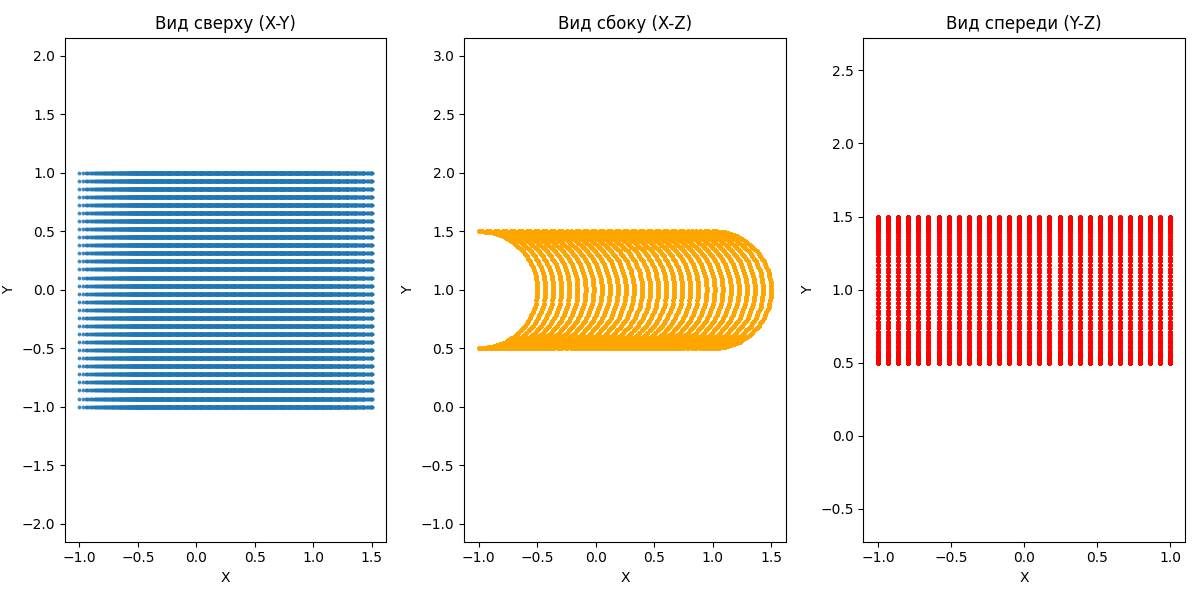

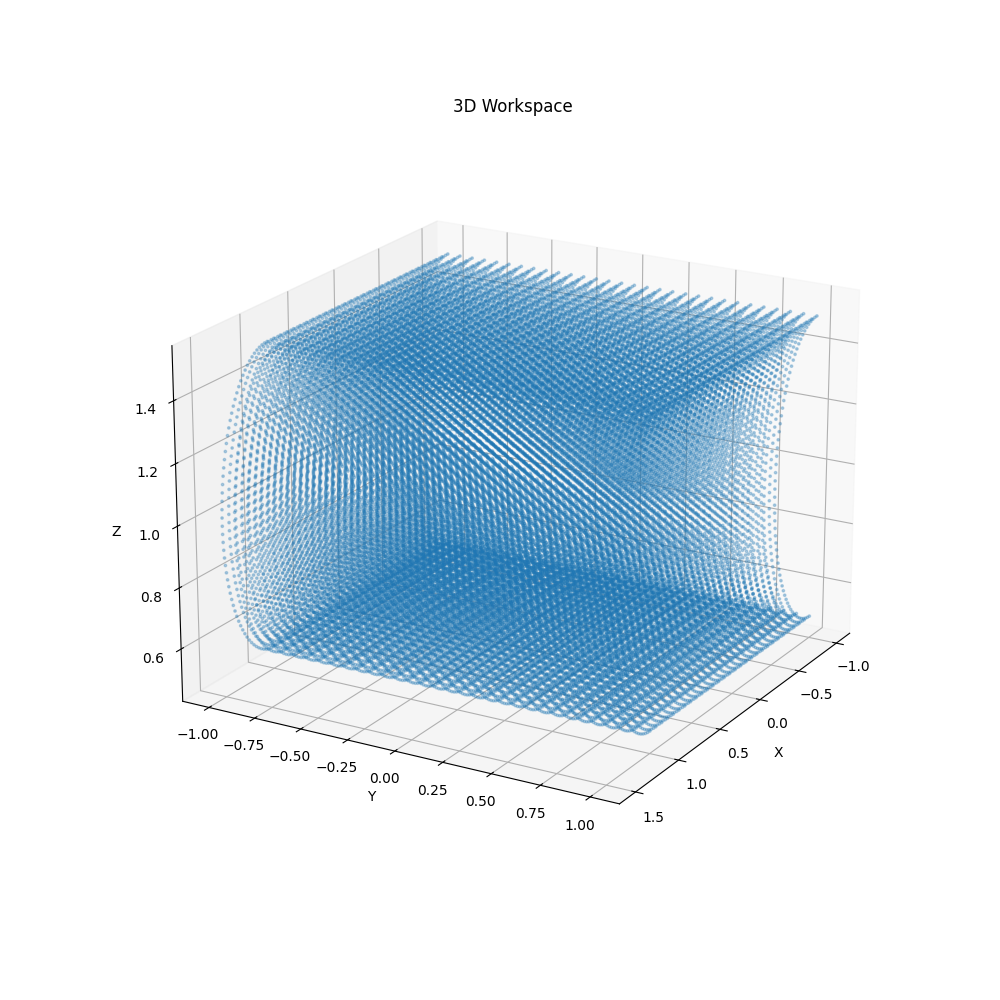

In [6]:
# --------------------------
# ЗАПУСК
# --------------------------
points = generate_workspace()
plot_projections(points)
plot_workspace_3d(points)


In [7]:
def set_axes_equal(ax):
    """Сделать масштабирование 3D-оси равным (одинаковая длина по X,Y,Z)."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim3d([mid_x - max_range, mid_x + max_range])
    ax.set_ylim3d([mid_y - max_range, mid_y + max_range])
    ax.set_zlim3d([mid_z - max_range, mid_z + max_range])


In [8]:
# --------------------------
# МАТРИЦЫ ПРЕОБРАЗОВАНИЙ
# --------------------------
def A1(q1):
    return np.array([
        [1, 0, 0, l1],
        [0, 0, 1, 0],
        [0,-1, 0, q1],
        [0, 0, 0, 1]
    ])

def A2(q2, q1):
    return np.array([
        [1, 0, 0, l1],
        [0, 1, 0, q2],
        [0, 0, 1, q1],
        [0, 0, 0, 1]
    ])

def A3(q3, q2, q1):
    """Конечное преобразование (из первой матрицы твоего диалога)."""
    return np.array([
        [np.cos(q3), -np.sin(q3), 0, l1 + l3*np.cos(q3)],
        [np.sin(q3),  np.cos(q3), 0, q2 + l3*np.sin(q3)],
        [0,           0,          1, q1],
        [0,           0,          0, 1]
    ])

In [9]:
# --------------------------
# ПЕРЕВОД В СИСТЕМУ ПОЛЬЗОВАТЕЛЯ
def Go2abs(v):
    return v[1], v[2], v[0]


# --------------------------
# ПРЯМАЯ КИНЕМАТИКА
# --------------------------
def forward_kinematics(q1, q2, q3):
    # последовательное умножение матриц
    T1 = A1(q1)
    T2 = A2(q2, q1)
    T3 = A3(q3, q2, q1)

    # Позиции всех узлов
    p0 = np.array([0,0,0,1])
    p1 = Go2abs(T1 @ np.array([0,0,0,1]))  # Узел 1
    p2 = Go2abs(T2 @ np.array([0,0,0,1]))  # Узел 2
    p3 = Go2abs(T3 @ np.array([0,0,0,1]))  # хват (Узел 3)

    return p0[:3], p1[:3], p2[:3], p3[:3], T3

In [10]:

# --- Рисовалка манипулятора ---
def plot_manipulator(q1=0, q2=0, q3=0):
    p0, p1, p2, p3, T = forward_kinematics(q1, q2, q3)

    # Создаем фигуру с большой левой колонкой для 3D и правой для проекций
    fig = plt.figure(figsize=(15, 6))
    gs = fig.add_gridspec(2, 4, width_ratios=[3,1,1,1], height_ratios=[1,1], wspace=0.7, hspace=0.3)

    # ---- 3D-график (левая большая область) ----
    ax1 = fig.add_subplot(gs[:,0], projection='3d')


    # Линии звеньев
    ax1.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], 'ro-')
    ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'go-')
    ax1.plot([p2[0], p3[0]], [p2[1], p3[1]], [p2[2], p3[2]], 'bo-')

    # Локальная СК в хвате
    R = T[:3,:3]
    origin = p3
    scale = 0.3
    colors = ['r','g','b']
    for i in range(3):

        basis_v = [R[0,i], R[1,i], R[2,i]]
        basis_v = Go2abs(basis_v)

        ax1.quiver(origin[0], origin[1], origin[2],
                  basis_v[0],  basis_v[1],  basis_v[2],
                  color=colors[i], length=scale, normalize=True)
        

    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    set_axes_equal(ax1)
    #plt.show()
        
    # ---- XY проекция (вид сверху) ----
    ax2 = fig.add_subplot(gs[0,1])

    # Линии звеньев
    ax2.plot([p0[0], p1[0]], [p0[1], p1[1]], 'ro-')
    ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], 'go-')
    ax2.plot([p2[0], p3[0]], [p2[1], p3[1]], 'bo-')
    ax2.set_title("Проекция XY (вид сверху)")
    ax2.set_xlabel("X"); ax2.set_ylabel("Y")
    ax2.axis('equal')

    # ---- XZ проекция (вид сбоку) ----
    ax3 = fig.add_subplot(gs[0,2])
        # Линии звеньев
    ax3.plot([p0[0], p1[0]],  [p0[2], p1[2]], 'ro-')
    ax3.plot([p1[0], p2[0]],  [p1[2], p2[2]], 'go-')
    ax3.plot([p2[0], p3[0]],  [p2[2], p3[2]], 'bo-')
    ax3.set_title("Проекция XZ (вид сбоку)")
    ax3.set_xlabel("X"); ax3.set_ylabel("Z")
    ax3.axis('equal')

    # ---- YZ проекция (вид спереди) ----
    ax4 = fig.add_subplot(gs[0,3])
        # Линии звеньев
    ax4.plot([p0[1], p1[1]], [p0[2], p1[2]], 'ro-')
    ax4.plot([p1[1], p2[1]], [p1[2], p2[2]], 'go-')
    ax4.plot([p2[1], p3[1]], [p2[2], p3[2]], 'bo-')
    ax4.set_title("Проекция YZ (вид спереди)")
    ax4.set_xlabel("Y"); ax4.set_ylabel("Z")
    ax4.axis('equal')

    # Отступы между графиками
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.show()



In [ ]:

# --- Интерактив ---
interact(plot_manipulator,
         q1=FloatSlider(min=-2, max=2, step=0.1, value=0),
         q2=FloatSlider(min=0, max=2, step=0.1, value=0),
         q3=FloatSlider(min=-np.pi/4, max=np.pi, step=0.1, value=0));

interactive(children=(FloatSlider(value=0.0, description='q1', max=2.0, min=-2.0), FloatSlider(value=0.0, desc…

In [12]:
# --- Рисовалка манипулятора ---
def plot_manipulator_only(q1=0, q2=0, q3=0):
    p0, p1, p2, p3, T = forward_kinematics(q1, q2, q3)

    # Создаем фигуру с большой левой колонкой для 3D и правой для проекций
    fig = plt.figure(figsize=(16, 6))

    # ---- 3D-график (левая большая область) ----
    ax1 = fig.add_subplot(111, projection='3d')

    # Линии звеньев
    ax1.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], 'ro-')
    ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'go-')
    ax1.plot([p2[0], p3[0]], [p2[1], p3[1]], [p2[2], p3[2]], 'bo-')

    # Локальная СК в хвате
    R = T[:3,:3]
    origin = p3
    scale = 0.3
    colors = ['r','g','b']
    for i in range(3):

        basis_v = [R[0,i], R[1,i], R[2,i]]
        basis_v = Go2abs(basis_v)

        ax1.quiver(origin[0], origin[1], origin[2],
                  basis_v[0],  basis_v[1],  basis_v[2],
                  color=colors[i], length=scale, normalize=True)
        

    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    set_axes_equal(ax1)
    plt.show()

In [ ]:
# --- Интерактив ---
interact(plot_manipulator_only,
         q1=FloatSlider(min=-2, max=2, step=0.1, value=0),
         q2=FloatSlider(min=0, max=2, step=0.1, value=0),
         q3=FloatSlider(min=-np.pi/4, max=np.pi, step=0.1, value=0));

interactive(children=(FloatSlider(value=0.0, description='q1', max=2.0, min=-2.0), FloatSlider(value=0.0, desc…